In [5]:
import os
import numpy as np
import cv2
import math
from keras.models import Sequential
from keras.layers import Dense
from copy import copy, deepcopy

from sklearn.datasets import load_boston
from sklearn.linear_model import ElasticNet,ElasticNetCV,Ridge,Lasso,LinearRegression,MultiTaskLasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
calib_dir = 'C:/kitti/training/calib/'
label_2_dir = 'C:/kitti/training/label_2/'
label_2_testing_dir = 'C:/kitti/testing/label_2/'
label_3_dir = 'C:/kitti/training/label_3/'

In [7]:
class Calibration(object):
    """ Calibration matrices and utils
        3d XYZ in <label>.txt are in rect camera coord.
        2d box xy are in image2 coord
        Points in <lidar>.bin are in Velodyne coord.

        y_image2 = P^2_rect * x_rect
        y_image2 = P^2_rect * R0_rect * Tr_velo_to_cam * x_velo
        x_ref = Tr_velo_to_cam * x_velo
        x_rect = R0_rect * x_ref

        P^2_rect = [f^2_u,  0,      c^2_u,  -f^2_u b^2_x;
                    0,      f^2_v,  c^2_v,  -f^2_v b^2_y;
                    0,      0,      1,      0]
                 = K * [1|t]

        image2 coord:
         ----> x-axis (u)
        |
        |
        v y-axis (v)

        velodyne coord:
        front x, left y, up z

        rect/ref camera coord:
        right x, down y, front z

        Ref (KITTI paper): http://www.cvlibs.net/publications/Geiger2013IJRR.pdf

        TODO(rqi): do matrix multiplication only once for each projection.
    """

    def __init__(self, calib_filepath, from_video=False):
        if from_video:
            calibs = self.read_calib_from_video(calib_filepath)
        else:
            calibs = self.read_calib_file(calib_filepath)
        # Projection matrix from rect camera coord to image2 coord
        self.P = calibs["P2"]
        self.P3 = calibs["P3"]
        self.P = np.reshape(self.P, [3, 4])
        self.P3 = np.reshape(self.P3, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        self.V2C = calibs["Tr_velo_to_cam"]
        self.V2C = np.reshape(self.V2C, [3, 4])
        self.C2V = inverse_rigid_trans(self.V2C)
        # Rotation from reference camera coord to rect camera coord
        self.R0 = calibs["R0_rect"]
        self.R0 = np.reshape(self.R0, [3, 3])

        # Camera intrinsics and extrinsics
        self.c_u = self.P[0, 2]
        self.c_v = self.P[1, 2]
        self.f_u = self.P[0, 0]
        self.f_v = self.P[1, 1]
        self.b_x = self.P[0, 3] / (-self.f_u)  # relative
        self.b_y = self.P[1, 3] / (-self.f_v)

    def read_calib_file(self, filepath):
        """ Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        """
        data = {}
        with open(filepath, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key, value = line.split(":", 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass

        return data

    def read_calib_from_video(self, calib_root_dir):
        """ Read calibration for camera 2 from video calib files.
            there are calib_cam_to_cam and calib_velo_to_cam under the calib_root_dir
        """
        data = {}
        cam2cam = self.read_calib_file(
            os.path.join(calib_root_dir, "calib_cam_to_cam.txt")
        )
        velo2cam = self.read_calib_file(
            os.path.join(calib_root_dir, "calib_velo_to_cam.txt")
        )
        Tr_velo_to_cam = np.zeros((3, 4))
        Tr_velo_to_cam[0:3, 0:3] = np.reshape(velo2cam["R"], [3, 3])
        Tr_velo_to_cam[:, 3] = velo2cam["T"]
        data["Tr_velo_to_cam"] = np.reshape(Tr_velo_to_cam, [12])
        data["R0_rect"] = cam2cam["R_rect_00"]
        data["P2"] = cam2cam["P_rect_02"]
        return data

    def cart2hom(self, pts_3d):
        """ Input: nx3 points in Cartesian
            Oupput: nx4 points in Homogeneous by pending 1
        """
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
        return pts_3d_hom

    # ===========================
    # ------- 3d to 3d ----------
    # ===========================
    def project_velo_to_ref(self, pts_3d_velo):
        pts_3d_velo = self.cart2hom(pts_3d_velo)  # nx4
        return np.dot(pts_3d_velo, np.transpose(self.V2C))

    def project_ref_to_velo(self, pts_3d_ref):
        pts_3d_ref = self.cart2hom(pts_3d_ref)  # nx4
        return np.dot(pts_3d_ref, np.transpose(self.C2V))

    def project_rect_to_ref(self, pts_3d_rect):
        """ Input and Output are nx3 points """
        return np.transpose(np.dot(np.linalg.inv(self.R0), np.transpose(pts_3d_rect)))

    def project_ref_to_rect(self, pts_3d_ref):
        """ Input and Output are nx3 points """
        return np.transpose(np.dot(self.R0, np.transpose(pts_3d_ref)))

    def project_rect_to_velo(self, pts_3d_rect):
        """ Input: nx3 points in rect camera coord.
            Output: nx3 points in velodyne coord.
        """
        pts_3d_ref = self.project_rect_to_ref(pts_3d_rect)
        return self.project_ref_to_velo(pts_3d_ref)

    def project_velo_to_rect(self, pts_3d_velo):
        pts_3d_ref = self.project_velo_to_ref(pts_3d_velo)
        return self.project_ref_to_rect(pts_3d_ref)

    # ===========================
    # ------- 3d to 2d ----------
    # ===========================
    def project_rect_to_image(self, pts_3d_rect):
        """ Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(self.P))  # nx3
        pts_2d[:, 0] /= pts_2d[:, 2]
        pts_2d[:, 1] /= pts_2d[:, 2]
        return pts_2d[:, 0:2]

    def project_rect_to_image_3(self, pts_3d_rect):
        """ Input: nx3 points in rect camera coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.cart2hom(pts_3d_rect)
        pts_2d = np.dot(pts_3d_rect, np.transpose(self.P3))  # nx3
        pts_2d[:, 0] /= pts_2d[:, 2]
        pts_2d[:, 1] /= pts_2d[:, 2]
        return pts_2d[:, 0:2]

    def project_velo_to_image(self, pts_3d_velo):
        """ Input: nx3 points in velodyne coord.
            Output: nx2 points in image2 coord.
        """
        pts_3d_rect = self.project_velo_to_rect(pts_3d_velo)
        return self.project_rect_to_image(pts_3d_rect)

    def project_8p_to_4p(self, pts_2d):
        x0 = np.min(pts_2d[:, 0])
        x1 = np.max(pts_2d[:, 0])
        y0 = np.min(pts_2d[:, 1])
        y1 = np.max(pts_2d[:, 1])
        x0 = max(0, x0)
        # x1 = min(x1, proj.image_width)
        y0 = max(0, y0)
        # y1 = min(y1, proj.image_height)
        return np.array([x0, y0, x1, y1])

    def project_velo_to_4p(self, pts_3d_velo):
        """ Input: nx3 points in velodyne coord.
            Output: 4 points in image2 coord.
        """
        pts_2d_velo = self.project_velo_to_image(pts_3d_velo)
        return self.project_8p_to_4p(pts_2d_velo)

    # ===========================
    # ------- 2d to 3d ----------
    # ===========================
    def project_image_to_rect(self, uv_depth):
        """ Input: nx3 first two channels are uv, 3rd channel
                   is depth in rect camera coord.
            Output: nx3 points in rect camera coord.
        """
        n = uv_depth.shape[0]
        x = ((uv_depth[:, 0] - self.c_u) * uv_depth[:, 2]) / self.f_u + self.b_x
        y = ((uv_depth[:, 1] - self.c_v) * uv_depth[:, 2]) / self.f_v + self.b_y
        pts_3d_rect = np.zeros((n, 3))
        pts_3d_rect[:, 0] = x
        pts_3d_rect[:, 1] = y
        pts_3d_rect[:, 2] = uv_depth[:, 2]
        return pts_3d_rect

    def project_image_to_velo(self, uv_depth):
        pts_3d_rect = self.project_image_to_rect(uv_depth)
        return self.project_rect_to_velo(pts_3d_rect)

    def project_depth_to_velo(self, depth, constraint_box=True):
        depth_pt3d = get_depth_pt3d(depth)
        depth_UVDepth = np.zeros_like(depth_pt3d)
        depth_UVDepth[:, 0] = depth_pt3d[:, 1]
        depth_UVDepth[:, 1] = depth_pt3d[:, 0]
        depth_UVDepth[:, 2] = depth_pt3d[:, 2]
        # print("depth_pt3d:",depth_UVDepth.shape)
        depth_pc_velo = self.project_image_to_velo(depth_UVDepth)
        # print("dep_pc_velo:",depth_pc_velo.shape)
        if constraint_box:
            depth_box_fov_inds = (
                (depth_pc_velo[:, 0] < cbox[0][1])
                & (depth_pc_velo[:, 0] >= cbox[0][0])
                & (depth_pc_velo[:, 1] < cbox[1][1])
                & (depth_pc_velo[:, 1] >= cbox[1][0])
                & (depth_pc_velo[:, 2] < cbox[2][1])
                & (depth_pc_velo[:, 2] >= cbox[2][0])
            )
            depth_pc_velo = depth_pc_velo[depth_box_fov_inds]
        return depth_pc_velo
        
class Object3d(object):
    """ 3d object label """

    def __init__(self, label_file_line):
        data = label_file_line.split(" ")
        data[1:] = [float(x) for x in data[1:]]

        # extract label, truncation, occlusion
        self.type = data[0]  # 'Car', 'Pedestrian', ...
        self.truncation = data[1]  # truncated pixel ratio [0..1]
        self.occlusion = int(
            data[2]
        )  # 0=visible, 1=partly occluded, 2=fully occluded, 3=unknown
        self.alpha = data[3]  # object observation angle [-pi..pi]

        # extract 2d bounding box in 0-based coordinates
        self.xmin = data[4]  # left
        self.ymin = data[5]  # top
        self.xmax = data[6]  # right
        self.ymax = data[7]  # bottom
        self.box2d = np.array([self.xmin, self.ymin, self.xmax, self.ymax])

        # extract 3d bounding box information
        self.h = data[8]  # box height
        self.w = data[9]  # box width
        self.l = data[10]  # box length (in meters)
        self.t = (data[11], data[12], data[13])  # location (x,y,z) in camera coord.
        self.ry = data[14]  # yaw angle (around Y-axis in camera coordinates) [-pi..pi]

    def estimate_diffculty(self):
        """ Function that estimate difficulty to detect the object as defined in kitti website"""
        # height of the bounding box
        bb_height = np.abs(self.xmax - self.xmin)

        if bb_height >= 40 and self.occlusion == 0 and self.truncation <= 0.15:
            return "Easy"
        elif bb_height >= 25 and self.occlusion in [0, 1] and self.truncation <= 0.30:
            return "Moderate"
        elif (
            bb_height >= 25 and self.occlusion in [0, 1, 2] and self.truncation <= 0.50
        ):
            return "Hard"
        else:
            return "Unknown"

    def print_object(self):
        print(
            "Type, truncation, occlusion, alpha: %s, %d, %d, %f"
            % (self.type, self.truncation, self.occlusion, self.alpha)
        )
        print(
            "2d bbox (x0,y0,x1,y1): %f, %f, %f, %f"
            % (self.xmin, self.ymin, self.xmax, self.ymax)
        )
        print("3d bbox h,w,l: %f, %f, %f" % (self.h, self.w, self.l))
        print(
            "3d bbox location, ry: (%f, %f, %f), %f"
            % (self.t[0], self.t[1], self.t[2], self.ry)
        )
        print("Difficulty of estimation: {}".format(self.estimate_diffculty()))

def compute_box_3d(obj, P):
    """ Takes an object and a projection matrix (P) and projects the 3d
        bounding box into the image plane.
        Returns:
            corners_2d: (8,2) array in left image coord.
            corners_3d: (8,3) array in in rect camera coord.
    """
    # compute rotational matrix around yaw axis
    R = roty(obj.ry)

    # 3d bounding box dimensions
    l = obj.l
    w = obj.w
    h = obj.h

    # 3d bounding box corners
    x_corners = [l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2]
    y_corners = [0, 0, 0, 0, -h, -h, -h, -h]
    z_corners = [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2]

    # rotate and translate 3d bounding box
    corners_3d = np.dot(R, np.vstack([x_corners, y_corners, z_corners]))
    # print corners_3d.shape
    corners_3d[0, :] = corners_3d[0, :] + obj.t[0]
    corners_3d[1, :] = corners_3d[1, :] + obj.t[1]
    corners_3d[2, :] = corners_3d[2, :] + obj.t[2]

    # project the 3d bounding box into the image plane
    corners_2d = project_to_image(np.transpose(corners_3d), P)
    # print 'corners_2d: ', corners_2d
    return corners_2d, np.transpose(corners_3d)

def rotx(t):
    """ 3D Rotation about the x-axis. """
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])


def roty(t):
    """ Rotation about the y-axis. """
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])


def rotz(t):
    """ Rotation about the z-axis. """
    c = np.cos(t)
    s = np.sin(t)
    return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])

def project_to_image(pts_3d, P):
    """ Project 3d points to image plane.

    Usage: pts_2d = projectToImage(pts_3d, P)
      input: pts_3d: nx3 matrix
             P:      3x4 projection matrix
      output: pts_2d: nx2 matrix

      P(3x4) dot pts_3d_extended(4xn) = projected_pts_2d(3xn)
      => normalize projected_pts_2d(2xn)

      <=> pts_3d_extended(nx4) dot P'(4x3) = projected_pts_2d(nx3)
          => normalize projected_pts_2d(nx2)
    """
    n = pts_3d.shape[0]
    pts_3d_extend = np.hstack((pts_3d, np.ones((n, 1))))
    # print(('pts_3d_extend shape: ', pts_3d_extend.shape)) 
    pts_2d = np.dot(pts_3d_extend, np.transpose(P))  # nx3
    pts_2d[:, 0] /= pts_2d[:, 2]
    pts_2d[:, 1] /= pts_2d[:, 2]
    return pts_2d[:, 0:2]

def read_label(label_filename):
    lines = [line.rstrip() for line in open(label_filename)]
    objects = [Object3d(line) for line in lines]
    return objects

def inverse_rigid_trans(Tr):
    """ Inverse a rigid body transform matrix (3x4 as [R|t])
        [R'|-R't; 0|1]
    """
    inv_Tr = np.zeros_like(Tr)  # 3x4
    inv_Tr[0:3, 0:3] = np.transpose(Tr[0:3, 0:3])
    inv_Tr[0:3, 3] = np.dot(-np.transpose(Tr[0:3, 0:3]), Tr[0:3, 3])
    return inv_Tr

def get_distance_for_object(object3d):
    return math.sqrt(object3d.t[0]**2 + object3d.t[1]**2 + object3d.t[2]**2)

In [27]:
files = os.listdir(label_2_dir)
dataset = []

classToInt = {
  "Car": 0,
  "Pedestrian": 1,
  "Misc": 2,
  "DontCare": 3,
  "Truck": 4,
  "Cyclist": 5,
  "Van": 6,
  "Tram": 7,
  "Person_sitting": 8
}

classes = []
                   
for file in files:
    if not file.endswith(".txt"):
        continue
    
    file_without_extension = os.path.splitext(file)[0]
    left_objects = read_label(os.path.join(label_2_dir, file))     
    calib = Calibration(os.path.join(calib_dir, file))
    
    right_objects = []
    for left_object in left_objects:
        if left_object.type != "Car" and left_object.type != "Pedestrian":
            continue
        
        dataset_row = np.zeros(9)
        
        box3d_left = compute_box_3d(left_object, calib.P)   
        left_object.xmin = min(box3d_left[0], key=lambda t: t[0])[0]
        left_object.xmax = max(box3d_left[0], key=lambda t: t[0])[0]
        left_object.ymin = min(box3d_left[0], key=lambda t: t[1])[1]
        left_object.ymax = max(box3d_left[0], key=lambda t: t[1])[1]
        dataset_row[0] = (left_object.xmin + left_object.xmax) / 2
        dataset_row[1] = (left_object.ymin + left_object.ymax) / 2
        dataset_row[2] = left_object.xmax - left_object.xmin
        dataset_row[3] = left_object.ymax - left_object.ymin
        
        box3d_right = compute_box_3d(left_object, calib.P3)      
        right_object = copy(left_object)
        right_object.xmin = min(box3d_right[0], key=lambda t: t[0])[0]
        right_object.xmax = max(box3d_right[0], key=lambda t: t[0])[0]
        right_object.ymin = min(box3d_right[0], key=lambda t: t[1])[1]
        right_object.ymax = max(box3d_right[0], key=lambda t: t[1])[1]
        dataset_row[4] = dataset_row[0] - ((right_object.xmin + right_object.xmax) / 2)
        dataset_row[5] = dataset_row[1] - ((right_object.ymin + right_object.ymax) / 2)
        dataset_row[6] = dataset_row[2] - (right_object.xmax - right_object.xmin)
        dataset_row[7] = dataset_row[3] - (right_object.ymax - right_object.ymin)
        classes.append(classToInt[left_object.type])
        dataset_row[8] = get_distance_for_object(left_object)
        
        dataset.append(np.asarray(dataset_row))
    
dataset = np.array(dataset)

In [28]:
from sklearn.model_selection import train_test_split
dataset_x_train,dataset_x_test,dataset_y_train,dataset_y_test = train_test_split(dataset[:, :8],dataset[:, 8],test_size = 0.25)

k = [2]
actuals = []
preds = []
for kval in k:
    print("k: ", kval)
    neigh = KNeighborsRegressor(n_neighbors=kval)
    neigh.fit(dataset_x_train, dataset_y_train)

    for i in range(0, len(dataset_x_test)):
        pred = neigh.predict([dataset_x_test[i]])
        preds.append(pred[0])
        actual = dataset_y_test[i]
        actuals.append(actual)
        
        print("predicted:, ", pred)
        print("actual: ", actual)
        print("\n")

k:  2
predicted:,  [46.74539898]
actual:  51.708101879686126


predicted:,  [16.42660945]
actual:  15.62122274343465


predicted:,  [23.14040154]
actual:  20.28241602965485


predicted:,  [8.89373588]
actual:  9.626286926951638


predicted:,  [41.8162593]
actual:  40.82849250217304


predicted:,  [7.34096521]
actual:  7.590559926645728


predicted:,  [26.53333367]
actual:  32.4592883470972


predicted:,  [21.8818664]
actual:  20.83921783560986


predicted:,  [34.48590526]
actual:  34.454031694418575


predicted:,  [10.23312238]
actual:  9.778353644658186


predicted:,  [27.98854051]
actual:  28.017912127779972


predicted:,  [19.21396184]
actual:  20.573480502822072


predicted:,  [23.43967745]
actual:  22.851041551754268


predicted:,  [30.21629137]
actual:  26.604574794572454


predicted:,  [27.49895604]
actual:  25.91046699694932


predicted:,  [37.72374287]
actual:  37.7186505591067


predicted:,  [26.52860844]
actual:  23.63467368084442


predicted:,  [11.74546543]
actual:  11.238

predicted:,  [48.18728229]
actual:  50.66191172863495


predicted:,  [59.43071589]
actual:  57.95856796022483


predicted:,  [17.15727276]
actual:  19.48949204058433


predicted:,  [11.65711364]
actual:  10.975622989151914


predicted:,  [30.38847901]
actual:  35.90493698643684


predicted:,  [20.05463912]
actual:  19.031269006558656


predicted:,  [4.03354043]
actual:  3.5271801768551607


predicted:,  [45.84281859]
actual:  56.13611048157861


predicted:,  [14.47850577]
actual:  15.074959369762825


predicted:,  [30.06926199]
actual:  31.054700127355922


predicted:,  [3.86238504]
actual:  4.12355429211257


predicted:,  [9.288619]
actual:  9.272033218232128


predicted:,  [15.14163713]
actual:  15.647971114492767


predicted:,  [5.85912405]
actual:  5.518387445622136


predicted:,  [76.18890416]
actual:  76.19263284596484


predicted:,  [25.76736713]
actual:  23.81533959447146


predicted:,  [22.91144088]
actual:  22.64662668036898


predicted:,  [20.31420031]
actual:  19.7630235541

predicted:,  [26.58042878]
actual:  26.251272350116672


predicted:,  [14.1610332]
actual:  14.841906885572353


predicted:,  [35.93339158]
actual:  33.78499963001332


predicted:,  [24.64195978]
actual:  23.574986744428937


predicted:,  [37.79453343]
actual:  36.968851753875185


predicted:,  [45.09254438]
actual:  44.603291358373994


predicted:,  [20.47896584]
actual:  22.504599529873886


predicted:,  [4.37512428]
actual:  4.213193563082522


predicted:,  [36.51544365]
actual:  38.398346318559085


predicted:,  [13.477735]
actual:  12.700322830542538


predicted:,  [26.74316753]
actual:  24.473497911005694


predicted:,  [16.93740766]
actual:  16.022740090259216


predicted:,  [37.42737158]
actual:  36.16179337366996


predicted:,  [15.50224101]
actual:  16.565476147699467


predicted:,  [15.06451195]
actual:  14.888186592060162


predicted:,  [23.96778939]
actual:  22.265188074660408


predicted:,  [69.35305557]
actual:  69.35727863750135


predicted:,  [50.92174312]
actual:  48.

predicted:,  [34.02068941]
actual:  34.11836015989046


predicted:,  [44.70022883]
actual:  48.64162929014611


predicted:,  [20.86831398]
actual:  20.54712875318593


predicted:,  [5.92980768]
actual:  6.066440471973659


predicted:,  [29.67986447]
actual:  29.67680744285005


predicted:,  [55.23833633]
actual:  55.22892086579277


predicted:,  [26.50265592]
actual:  24.184255208709654


predicted:,  [37.92820342]
actual:  36.43547447200324


predicted:,  [52.4022236]
actual:  61.807949326927194


predicted:,  [47.98386322]
actual:  46.23165149548521


predicted:,  [9.54817122]
actual:  10.204807690495691


predicted:,  [45.88560315]
actual:  41.44557033025363


predicted:,  [24.44245587]
actual:  23.709164894614066


predicted:,  [31.78552925]
actual:  31.94954929259566


predicted:,  [46.0947623]
actual:  46.08960511872498


predicted:,  [38.58207203]
actual:  38.576114371460484


predicted:,  [29.39242301]
actual:  31.25486522127395


predicted:,  [34.41653496]
actual:  34.73285908

predicted:,  [41.02113224]
actual:  42.99510902416692


predicted:,  [12.73600058]
actual:  12.3485424241082


predicted:,  [26.22652725]
actual:  26.046230053502946


predicted:,  [15.53376008]
actual:  16.44880846748481


predicted:,  [47.26508106]
actual:  58.60827671924845


predicted:,  [29.12166627]
actual:  25.48824631079981


predicted:,  [45.36710054]
actual:  48.65911117149592


predicted:,  [22.70557193]
actual:  24.952973770675108


predicted:,  [44.06331437]
actual:  43.37085772728043


predicted:,  [6.04818392]
actual:  6.229357912337354


predicted:,  [8.20743488]
actual:  8.722436586183932


predicted:,  [50.51043731]
actual:  53.61819933567333


predicted:,  [24.05258316]
actual:  28.278544870625858


predicted:,  [51.6535351]
actual:  44.60427782175158


predicted:,  [49.31243669]
actual:  52.82821689211173


predicted:,  [45.03329099]
actual:  44.70742332096539


predicted:,  [14.1647904]
actual:  13.681480183079607


predicted:,  [34.43713156]
actual:  32.8639985394

predicted:,  [30.58289442]
actual:  36.91658976666182


predicted:,  [30.1935776]
actual:  30.28960217632447


predicted:,  [46.41281677]
actual:  46.40819324214206


predicted:,  [20.93045979]
actual:  19.9391549469881


predicted:,  [13.04598725]
actual:  12.013463280836213


predicted:,  [39.40493725]
actual:  39.404980649658995


predicted:,  [44.04707712]
actual:  41.66761572252485


predicted:,  [44.06462719]
actual:  47.83248477760694


predicted:,  [14.67722402]
actual:  13.94984587728481


predicted:,  [24.19216686]
actual:  22.870190204718458


predicted:,  [23.52653933]
actual:  22.82841431199285


predicted:,  [10.32568057]
actual:  9.44623734616064


predicted:,  [23.70437881]
actual:  22.528910315414723


predicted:,  [52.52556557]
actual:  48.129277991675714


predicted:,  [28.26735881]
actual:  29.816146632319878


predicted:,  [17.69037009]
actual:  16.57059141974118


predicted:,  [20.57721511]
actual:  20.321525533286124


predicted:,  [27.0098287]
actual:  28.493658

predicted:,  [40.78051844]
actual:  49.960148118275235


predicted:,  [72.91228121]
actual:  68.87543756666814


predicted:,  [28.06290046]
actual:  24.89556185347099


predicted:,  [65.09903717]
actual:  64.94908313440614


predicted:,  [21.70632519]
actual:  19.175145371026524


predicted:,  [37.6258625]
actual:  36.9739016064034


predicted:,  [13.73264205]
actual:  13.115170605066485


predicted:,  [10.99758694]
actual:  11.108870329605976


predicted:,  [53.0013685]
actual:  52.98845723362778


predicted:,  [52.7796293]
actual:  52.85842979128306


predicted:,  [31.60112505]
actual:  33.21151908600388


predicted:,  [23.50336471]
actual:  23.013476486615403


predicted:,  [45.47428884]
actual:  44.55180692182978


predicted:,  [24.34384254]
actual:  24.371462820274044


predicted:,  [22.75874232]
actual:  22.792248682392003


predicted:,  [5.25110872]
actual:  5.363077474734073


predicted:,  [13.8415232]
actual:  15.075244608297405


predicted:,  [23.78058714]
actual:  21.5968261

predicted:,  [27.00795951]
actual:  26.93091903370548


predicted:,  [10.52404527]
actual:  10.843989118401032


predicted:,  [22.77433769]
actual:  23.436320103634017


predicted:,  [48.45375569]
actual:  46.827056281598566


predicted:,  [27.46583014]
actual:  25.46166923043342


predicted:,  [11.79294027]
actual:  11.47147331426962


predicted:,  [8.47481555]
actual:  8.572829171282956


predicted:,  [40.5734316]
actual:  44.81418190707044


predicted:,  [37.38170011]
actual:  37.168872729745246


predicted:,  [65.05795438]
actual:  65.94228158018193


predicted:,  [12.59150134]
actual:  12.088978451465618


predicted:,  [24.89397471]
actual:  25.991577481945953


predicted:,  [48.29693805]
actual:  41.746766341837784


predicted:,  [33.44219668]
actual:  34.67793534799902


predicted:,  [22.7704879]
actual:  22.52640006747638


predicted:,  [18.65297916]
actual:  21.12909841900501


predicted:,  [10.42094787]
actual:  10.25674899761128


predicted:,  [37.88671514]
actual:  38.37132

predicted:,  [55.63671493]
actual:  57.69399015495462


predicted:,  [6.98816659]
actual:  7.359714668382192


predicted:,  [48.49724831]
actual:  59.60153185950844


predicted:,  [23.46527053]
actual:  23.740857187557488


predicted:,  [34.57364644]
actual:  37.238701642243115


predicted:,  [36.45991599]
actual:  33.981261012505115


predicted:,  [15.49732233]
actual:  14.26059606047377


predicted:,  [23.94742429]
actual:  21.70458476912194


predicted:,  [9.01628404]
actual:  9.916072811350269


predicted:,  [48.20636119]
actual:  50.43098650631375


predicted:,  [33.26873161]
actual:  28.905672453689778


predicted:,  [47.92556905]
actual:  47.925551640017666


predicted:,  [13.81799947]
actual:  13.321565223351197


predicted:,  [16.55963547]
actual:  16.168531163961678


predicted:,  [19.2549152]
actual:  20.072511053677363


predicted:,  [6.21750235]
actual:  6.415130552062055


predicted:,  [3.89364233]
actual:  4.348827428169575


predicted:,  [6.97219663]
actual:  6.89615835

predicted:,  [5.55617325]
actual:  5.494706543574461


predicted:,  [31.12431287]
actual:  29.01835453639644


predicted:,  [37.0242691]
actual:  34.19124449329097


predicted:,  [42.48462756]
actual:  44.1953312013837


predicted:,  [11.20053882]
actual:  11.37756564472383


predicted:,  [23.95607953]
actual:  21.262763225883884


predicted:,  [32.58868923]
actual:  31.26218642385718


predicted:,  [17.70773815]
actual:  18.34429066494532


predicted:,  [14.07949373]
actual:  17.699302246133886


predicted:,  [19.88740479]
actual:  18.827766728956462


predicted:,  [38.16318448]
actual:  36.733284633966505


predicted:,  [40.33530249]
actual:  39.59234900836272


predicted:,  [31.03042415]
actual:  27.991872034574605


predicted:,  [10.14612306]
actual:  11.012079730913685


predicted:,  [20.83371127]
actual:  19.81923308304335


predicted:,  [24.37403332]
actual:  24.647797061806557


predicted:,  [16.15661258]
actual:  14.70033332955413


predicted:,  [8.38056124]
actual:  8.1400982

predicted:,  [8.50078464]
actual:  8.78032459536662


predicted:,  [12.58193721]
actual:  11.016015613641805


predicted:,  [38.34689225]
actual:  36.95981736967866


predicted:,  [8.77684193]
actual:  9.124768490213874


predicted:,  [51.92945051]
actual:  52.30609237937776


predicted:,  [42.10335347]
actual:  39.58032971060246


predicted:,  [29.51727328]
actual:  28.90641105360539


predicted:,  [8.76816106]
actual:  8.60133129230586


predicted:,  [31.32935445]
actual:  30.056643192479097


predicted:,  [28.82874549]
actual:  30.712897942069873


predicted:,  [8.48137472]
actual:  8.409381665735001


predicted:,  [28.50537189]
actual:  27.15633443600222


predicted:,  [3.47676882]
actual:  3.5809495947304257


predicted:,  [36.29096888]
actual:  36.219145489644006


predicted:,  [46.05868564]
actual:  40.65250545784355


predicted:,  [27.30384467]
actual:  25.493044149336107


predicted:,  [12.37812388]
actual:  12.103177268800122


predicted:,  [48.47075657]
actual:  42.619811121

predicted:,  [34.27647862]
actual:  35.99143509225494


predicted:,  [16.28357915]
actual:  16.250279997587732


predicted:,  [23.79842374]
actual:  23.83689996622883


predicted:,  [16.86648807]
actual:  16.21876690750564


predicted:,  [20.56639658]
actual:  21.393283992879635


predicted:,  [17.4257677]
actual:  17.058739695534367


predicted:,  [39.305241]
actual:  39.83025734287942


predicted:,  [10.23984794]
actual:  10.51538396826288


predicted:,  [32.14425529]
actual:  32.164648295916436


predicted:,  [8.1978917]
actual:  7.96523069345766


predicted:,  [20.82717815]
actual:  25.387437838427097


predicted:,  [25.77120262]
actual:  29.731461450793166


predicted:,  [6.48183702]
actual:  6.196926657626343


predicted:,  [15.08921531]
actual:  15.082579355004235


predicted:,  [52.44394066]
actual:  54.50368611387673


predicted:,  [36.73663997]
actual:  46.806479252342825


predicted:,  [25.46431342]
actual:  26.81016598232842


predicted:,  [7.50094683]
actual:  6.8569380921

predicted:,  [24.32742654]
actual:  22.809342384207397


predicted:,  [23.94742429]
actual:  20.876295169402066


predicted:,  [30.62650958]
actual:  30.54679361242355


predicted:,  [31.12272024]
actual:  34.740949900657576


predicted:,  [55.0696326]
actual:  52.735564849539635


predicted:,  [22.4794789]
actual:  20.88644057756132


predicted:,  [31.34896984]
actual:  36.45714744737992


predicted:,  [16.81079998]
actual:  15.902858233663531


predicted:,  [40.70106005]
actual:  38.017832657846235


predicted:,  [41.7440952]
actual:  40.991452767619734


predicted:,  [30.00790749]
actual:  28.843045955654546


predicted:,  [50.57486492]
actual:  47.711383337731895


predicted:,  [50.61627761]
actual:  50.59239666194912


predicted:,  [28.04284066]
actual:  31.16697932106992


predicted:,  [15.64190047]
actual:  16.227020675404344


predicted:,  [42.38864171]
actual:  43.8994168526189


predicted:,  [54.40287626]
actual:  46.24253128884707


predicted:,  [51.29137364]
actual:  51.291

predicted:,  [39.70544923]
actual:  45.39945594387668


predicted:,  [41.50471675]
actual:  38.67910159246205


predicted:,  [32.23036689]
actual:  36.17427815451194


predicted:,  [42.76388766]
actual:  41.489538440430984


predicted:,  [14.82869523]
actual:  14.215607619795925


predicted:,  [28.98963291]
actual:  29.012145732434202


predicted:,  [56.18532382]
actual:  51.65941637300987


predicted:,  [4.43962979]
actual:  4.219431241293073


predicted:,  [33.87658627]
actual:  33.90554231980371


predicted:,  [3.8681045]
actual:  3.1497301471713413


predicted:,  [8.12818602]
actual:  7.853158600206671


predicted:,  [25.00989624]
actual:  25.014679690133953


predicted:,  [4.28702927]
actual:  4.079044005646421


predicted:,  [14.54443147]
actual:  16.222336453174677


predicted:,  [13.68330958]
actual:  12.983397090130149


predicted:,  [31.72749911]
actual:  31.72749911354502


predicted:,  [18.7831543]
actual:  19.158199289077253


predicted:,  [35.69743579]
actual:  33.2282545

predicted:,  [23.61925459]
actual:  26.581305460793306


predicted:,  [25.59078864]
actual:  26.246058751744044


predicted:,  [36.93997728]
actual:  32.775024027451146


predicted:,  [9.43627409]
actual:  9.304864319268711


predicted:,  [26.28071952]
actual:  25.237036276076477


predicted:,  [18.50604481]
actual:  17.269533867478877


predicted:,  [4.22220375]
actual:  4.1713906554049816


predicted:,  [27.39918694]
actual:  25.271044695461246


predicted:,  [23.7667448]
actual:  24.052330448420168


predicted:,  [24.90243141]
actual:  24.320692835525882


predicted:,  [32.29517271]
actual:  33.93556688785381


predicted:,  [14.51117495]
actual:  14.519986225888783


predicted:,  [38.00094245]
actual:  40.38123574136878


predicted:,  [3.99851399]
actual:  4.105727706509529


predicted:,  [14.09856808]
actual:  13.360254488594146


predicted:,  [43.30686484]
actual:  43.13869029073553


predicted:,  [32.93488023]
actual:  30.6441152588878


predicted:,  [43.36384003]
actual:  44.013

predicted:,  [8.36393208]
actual:  7.575889386732094


predicted:,  [53.64818565]
actual:  56.26142372887483


predicted:,  [25.25440155]
actual:  25.995001442585075


predicted:,  [31.81228787]
actual:  30.20444669249877


predicted:,  [9.97411958]
actual:  9.891339646377533


predicted:,  [15.73558004]
actual:  15.141740322697387


predicted:,  [13.72348677]
actual:  14.154974390651507


predicted:,  [50.92511048]
actual:  45.20701494237372


predicted:,  [18.60697427]
actual:  17.896058225207025


predicted:,  [73.33149492]
actual:  68.32625337306298


predicted:,  [17.06525148]
actual:  17.114534758502785


predicted:,  [19.82918422]
actual:  20.326172782892503


predicted:,  [26.65640815]
actual:  27.215822603772242


predicted:,  [18.44346628]
actual:  17.617340889021815


predicted:,  [8.33811896]
actual:  8.210883021941063


predicted:,  [26.81188433]
actual:  26.067736764053762


predicted:,  [14.97822737]
actual:  16.16279060063577


predicted:,  [28.41128407]
actual:  25.296

predicted:,  [57.16740962]
actual:  55.80596742284825


predicted:,  [13.75436742]
actual:  13.99394869220264


predicted:,  [36.89486741]
actual:  37.3954823474708


predicted:,  [13.23194577]
actual:  13.446858369150766


predicted:,  [46.92455196]
actual:  47.952662074174775


predicted:,  [28.595452]
actual:  29.430756021549975


predicted:,  [23.39189109]
actual:  20.744755963857468


predicted:,  [22.09741469]
actual:  20.33118294640034


predicted:,  [42.54120636]
actual:  49.79147115721727


predicted:,  [20.4881399]
actual:  20.811268582188834


predicted:,  [40.54906069]
actual:  39.926565091427534


predicted:,  [39.87910349]
actual:  51.73233224976427


predicted:,  [11.73252383]
actual:  11.146595892917263


predicted:,  [4.48598977]
actual:  5.1272409734671145


predicted:,  [12.72772503]
actual:  12.701562895958906


predicted:,  [24.33868718]
actual:  24.36427097206071


predicted:,  [13.58444983]
actual:  13.539150638057027


predicted:,  [34.38126102]
actual:  30.7644

predicted:,  [29.54924694]
actual:  29.544777880363224


predicted:,  [32.69487562]
actual:  29.171741463272294


predicted:,  [5.41628971]
actual:  5.221350400040204


predicted:,  [5.27310249]
actual:  5.058468147571951


predicted:,  [34.4853521]
actual:  34.038804326826764


predicted:,  [15.67642014]
actual:  16.094862534361702


predicted:,  [24.84086957]
actual:  27.484375561398515


predicted:,  [11.06994073]
actual:  11.563399154227964


predicted:,  [45.37281347]
actual:  37.532563195177595


predicted:,  [18.07162022]
actual:  17.669674586703632


predicted:,  [44.39076357]
actual:  37.63449215812537


predicted:,  [6.93545896]
actual:  6.686224644745344


predicted:,  [9.55301395]
actual:  9.964537119204284


predicted:,  [46.87302764]
actual:  46.8439665271847


predicted:,  [14.33562077]
actual:  13.905081804865443


predicted:,  [31.07812132]
actual:  35.14515756117761


predicted:,  [26.88746361]
actual:  23.6208467248742


predicted:,  [34.38987467]
actual:  37.2506993

predicted:,  [16.96454527]
actual:  17.077025502118335


predicted:,  [11.8038826]
actual:  11.750936132921495


predicted:,  [10.18467848]
actual:  9.940276656109729


predicted:,  [29.31747191]
actual:  29.236229237027132


predicted:,  [37.85305665]
actual:  47.89279799719369


predicted:,  [3.45569742]
actual:  3.634969050762331


predicted:,  [20.74783471]
actual:  20.74271197312444


predicted:,  [9.20334013]
actual:  8.896774696484114


predicted:,  [50.81469471]
actual:  51.71335707532436


predicted:,  [33.8170904]
actual:  33.38687466655122


predicted:,  [25.8487856]
actual:  24.70844794801972


predicted:,  [41.77153668]
actual:  48.43873243593396


predicted:,  [15.72686316]
actual:  15.980153315910332


predicted:,  [19.133362]
actual:  18.27572707172002


predicted:,  [11.87927602]
actual:  11.969899748953623


predicted:,  [53.18053746]
actual:  49.71961484162966


predicted:,  [32.41480393]
actual:  29.988976307970237


predicted:,  [35.00121852]
actual:  34.5677045810

predicted:,  [21.15311337]
actual:  20.515574571529797


predicted:,  [18.1372437]
actual:  17.723309510359517


predicted:,  [30.6480527]
actual:  29.23868328088664


predicted:,  [41.51538717]
actual:  40.44781823535109


predicted:,  [24.88517107]
actual:  23.625818504339698


predicted:,  [18.39232053]
actual:  17.04062498853842


predicted:,  [45.53358009]
actual:  44.95391084210583


predicted:,  [41.64654883]
actual:  41.64936133964122


predicted:,  [4.52999476]
actual:  5.115632903170438


predicted:,  [51.08414087]
actual:  46.72161919283192


predicted:,  [33.39679904]
actual:  33.59310941249708


predicted:,  [30.01726455]
actual:  29.786181359818517


predicted:,  [46.93908234]
actual:  46.90315980826878


predicted:,  [41.7173184]
actual:  45.522541668935844


predicted:,  [59.86146129]
actual:  59.28090586352405


predicted:,  [40.34095688]
actual:  45.097291492948884


predicted:,  [34.63699843]
actual:  34.63989751716942


predicted:,  [21.65530907]
actual:  21.6608148

predicted:,  [41.33088164]
actual:  39.69545691889691


predicted:,  [10.06155234]
actual:  10.690187089101855


predicted:,  [44.65084376]
actual:  45.96903958100495


predicted:,  [18.49842009]
actual:  17.320075057574087


predicted:,  [69.02079768]
actual:  67.55151515695262


predicted:,  [20.93820365]
actual:  20.94225871294689


predicted:,  [37.15633205]
actual:  37.410303393583966


predicted:,  [34.09773752]
actual:  34.098630471032116


predicted:,  [6.4847503]
actual:  5.941077343378051


predicted:,  [26.35137644]
actual:  26.16524603362254


predicted:,  [60.85431194]
actual:  60.84905422436737


predicted:,  [6.21997535]
actual:  6.486801985570393


predicted:,  [22.36684398]
actual:  22.371834971678116


predicted:,  [13.97191527]
actual:  13.661617766575084


predicted:,  [13.09591899]
actual:  12.882814133565693


predicted:,  [21.9048181]
actual:  21.608091077186803


predicted:,  [70.54667685]
actual:  73.08860649923488


predicted:,  [24.91765923]
actual:  27.54543

predicted:,  [6.80948518]
actual:  6.910962306365156


predicted:,  [48.61468021]
actual:  49.335048393611615


predicted:,  [11.2796701]
actual:  10.267005405667224


predicted:,  [48.50961791]
actual:  56.18587455935878


predicted:,  [3.65091075]
actual:  3.7167996986655067


predicted:,  [65.13625192]
actual:  61.29669566950571


predicted:,  [16.22855721]
actual:  18.888795620684764


predicted:,  [24.56993556]
actual:  23.856663639327273


predicted:,  [18.78108515]
actual:  17.148647176964136


predicted:,  [13.86802893]
actual:  13.94414931073244


predicted:,  [34.86886138]
actual:  35.2384647792721


predicted:,  [62.33430627]
actual:  66.45550842481006


predicted:,  [32.28279466]
actual:  35.36386998053239


predicted:,  [5.70847098]
actual:  5.612940405883533


predicted:,  [10.02569255]
actual:  10.273757832458385


predicted:,  [34.28959576]
actual:  36.470533311154085


predicted:,  [22.33659926]
actual:  21.39340786317131


predicted:,  [14.56135566]
actual:  13.995438

predicted:,  [59.33853333]
actual:  61.56528242443138


predicted:,  [21.20792213]
actual:  20.387608981928214


predicted:,  [55.87221663]
actual:  47.897981168312306


predicted:,  [27.92544596]
actual:  28.17230909953957


predicted:,  [19.63221735]
actual:  18.556740015422967


predicted:,  [5.64698566]
actual:  5.482198464120028


predicted:,  [33.28802471]
actual:  33.376365889653115


predicted:,  [23.13398062]
actual:  23.465738854764407


predicted:,  [14.67598805]
actual:  17.098830369355678


predicted:,  [19.18655235]
actual:  21.23945385361874


predicted:,  [24.4851813]
actual:  24.916219616948315


predicted:,  [29.97443842]
actual:  37.16761628084319


predicted:,  [11.79663413]
actual:  11.777240763438607


predicted:,  [34.92398455]
actual:  44.00136475156197


predicted:,  [11.32006448]
actual:  10.582050840928709


predicted:,  [15.58067244]
actual:  15.369154173213307


predicted:,  [17.88667787]
actual:  17.530308040647775


predicted:,  [8.34434055]
actual:  8.21

actual:  14.537940019136135


predicted:,  [22.4497242]
actual:  23.11996107263159


predicted:,  [16.0375806]
actual:  14.696958869099417


predicted:,  [53.3084339]
actual:  51.16394433583087


predicted:,  [10.64403264]
actual:  10.015213427581061


predicted:,  [19.02699154]
actual:  17.256734917127282


predicted:,  [33.49758188]
actual:  32.13972775242503


predicted:,  [8.12818602]
actual:  7.983263743607623


predicted:,  [12.89502428]
actual:  13.039348143216364


predicted:,  [8.76835171]
actual:  10.299092193004197


predicted:,  [20.55291711]
actual:  22.927304682408703


predicted:,  [32.45959384]
actual:  30.756965064843445


predicted:,  [23.01377595]
actual:  22.138854983941698


predicted:,  [18.70692988]
actual:  17.426296221515344


predicted:,  [37.71884012]
actual:  37.70884511623235


predicted:,  [30.74112774]
actual:  30.71898598586874


predicted:,  [19.80373897]
actual:  19.879330974658075


predicted:,  [10.11885572]
actual:  11.03507589461894


predicted:,  

predicted:,  [13.97624945]
actual:  14.052522905158348


predicted:,  [15.46941079]
actual:  15.132881417628305


predicted:,  [25.75623417]
actual:  26.938355554858948


predicted:,  [20.81099931]
actual:  21.929261273467468


predicted:,  [13.54257708]
actual:  12.710566470460709


predicted:,  [34.11588853]
actual:  34.127682312164126


predicted:,  [38.7286951]
actual:  40.42827970616608


predicted:,  [25.35315826]
actual:  27.52791673919405


predicted:,  [20.75437484]
actual:  21.62015263590893


predicted:,  [22.72007712]
actual:  21.769044535762244


predicted:,  [23.77995195]
actual:  22.206490042327715


predicted:,  [30.68014067]
actual:  30.940478341486575


predicted:,  [22.65610111]
actual:  22.199484228242785


predicted:,  [32.60985673]
actual:  34.803915009665225


predicted:,  [24.02527006]
actual:  24.191672120793964


predicted:,  [22.21350615]
actual:  19.728218368621125


predicted:,  [32.30850045]
actual:  35.61457847567482


predicted:,  [28.76987034]
actual:  

predicted:,  [78.1734137]
actual:  78.16872904173383


predicted:,  [26.60363046]
actual:  31.41883988946759


predicted:,  [41.82838905]
actual:  40.93022599497833


predicted:,  [41.90289762]
actual:  41.89769206054195


predicted:,  [20.16145322]
actual:  20.141631016379982


predicted:,  [24.19022928]
actual:  24.198952456666383


predicted:,  [9.01152628]
actual:  9.640508285355084


predicted:,  [33.63896717]
actual:  33.78716472271682


predicted:,  [57.53296995]
actual:  60.130017462162776


predicted:,  [19.23453094]
actual:  19.013295348255653


predicted:,  [16.56901059]
actual:  17.445079535502266


predicted:,  [12.70333849]
actual:  13.79193242442842


predicted:,  [27.77128674]
actual:  27.59620626100624


predicted:,  [8.19538502]
actual:  7.361358570264051


predicted:,  [25.67956794]
actual:  24.252028781114376


predicted:,  [20.12065218]
actual:  20.372427444956088


predicted:,  [56.38284901]
actual:  45.3940139225427


predicted:,  [3.7393662]
actual:  4.309628754

actual:  33.7899363716477


predicted:,  [35.17855864]
actual:  35.54254633534294


predicted:,  [48.84468081]
actual:  49.973906191131384


predicted:,  [35.65984603]
actual:  27.989283663573815


predicted:,  [31.64632109]
actual:  30.41866696619035


predicted:,  [36.66818331]
actual:  36.347155321978086


predicted:,  [11.93963067]
actual:  12.484346198339741


predicted:,  [33.03506446]
actual:  41.19885799388133


predicted:,  [54.26821152]
actual:  49.184906221319565


predicted:,  [13.02916008]
actual:  11.560320064773293


predicted:,  [42.18814492]
actual:  41.29025793089697


predicted:,  [9.5402915]
actual:  9.58167521887483


predicted:,  [14.83707317]
actual:  13.86457355997652


predicted:,  [30.80936129]
actual:  25.09525054666719


predicted:,  [44.85529111]
actual:  52.79789389738951


predicted:,  [31.91024759]
actual:  31.54669237812421


predicted:,  [51.46995272]
actual:  51.12299189210272


predicted:,  [19.66686629]
actual:  19.302675980288328


predicted:,  [53



predicted:,  [21.54505371]
actual:  22.57457640798604


predicted:,  [48.30957934]
actual:  49.394179819083945


predicted:,  [6.11745582]
actual:  6.2487518753747935


predicted:,  [21.81334498]
actual:  19.36574294985865


predicted:,  [34.80421904]
actual:  35.38006924809504


predicted:,  [11.59586595]
actual:  10.809518953218964


predicted:,  [23.01795903]
actual:  21.147344987019054


predicted:,  [60.24078326]
actual:  60.23218408791101


predicted:,  [35.08964496]
actual:  32.96516039700095


predicted:,  [26.29993015]
actual:  23.941858741543022


predicted:,  [43.67070944]
actual:  43.158797480930815


predicted:,  [9.60939215]
actual:  9.271860654690622


predicted:,  [37.28793351]
actual:  36.48245194610691


predicted:,  [32.79462767]
actual:  28.55268463735065


predicted:,  [10.0412554]
actual:  9.869751769928158


predicted:,  [4.1239623]
actual:  4.632008203792389


predicted:,  [49.27201382]
actual:  52.24313734836375


predicted:,  [22.77942447]
actual:  22.296995

In [37]:
diff = np.asarray(preds) - np.asarray(actuals)
percentDiff = (diff / actuals) * 100
absPercentDiff = np.abs(percentDiff)
absDiff = np.abs(diff)
mean = np.mean(absDiff)
std = np.std(absDiff)

print("[INFO] mean error: {:.2f}, std error: {:.2f}".format(mean, std))
print("[INFO] mean squared error: ", mean_squared_error(actuals, preds))

[INFO] mean error: 1.36, std error: 1.94
[INFO] mean squared error:  5.61187624997993


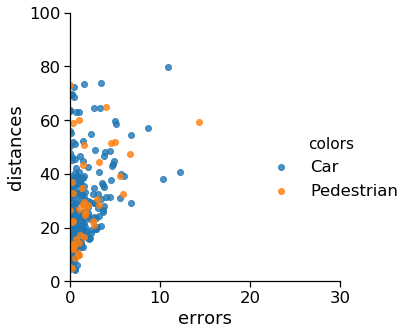

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

errors = np.abs(diff[:300])
distances = actuals[:300]
colors = classes[:300]
intToClass = {v: k for k, v in classToInt.items()}
df = pd.DataFrame(dict(errors=errors, distances=distances, colors=colors))
with sns.plotting_context("notebook", font_scale=1.5):
    g = sns.lmplot('errors', 'distances', data=df, hue='colors', fit_reg=False)
    g.set(ylim=(0, 100))
    g.set(xlim=(0, 30))
    for t in g._legend.texts: t.set_text(intToClass[int(float(t.get_text()))])
    plt.show()

In [5]:
dataset[0]

array([ 7.65368844e+02,  2.25794478e+02,  1.09848433e+02,  1.63584809e+02,
        4.50274685e+01, -3.76867708e-01,  2.60981632e+00, -3.56496812e-02,
        8.73353308e+00])

In [31]:
preds[0]

46.74539898171578

In [32]:
actuals[0]

51.708101879686126

In [33]:
diff[0]

-4.962702897970345

In [35]:
percentDiff[0]

-9.59753446281496